In [1]:
%reset -f
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose

In [2]:
from scripts.mnistParity import MNISTParityVertical, MNISTParityHorizontal
from scripts.architecture import MLP
from scripts.train_utils import accuracy
from scripts.train import train_epoch, train_model, test_model
from scripts.plot_utils import plot_loss_accuracy

In [3]:
print(torch.__version__)

1.8.1+cu102


## Create Parity Data Iterator

### Vertical

In [4]:
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

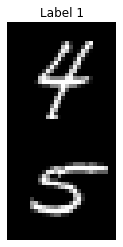

In [5]:
parityData2 = MNISTParityVertical(2, transforms = transforms)
parityData2.plotRandomData()

In [6]:
trainloaderParity2 = DataLoader(parityData2.trainset, batch_size=256, shuffle=True)
testloaderParity2 = DataLoader(parityData2.testset, batch_size=512, shuffle=True)

### Neural Network Part

In [7]:
inputShape0, inputShape1 = parityData2.trainset.data[0].shape
print(inputShape0 * inputShape1)

1568


In [8]:
learn_rate = 0.1 # for SGD
num_epochs = 20
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
model = MLP(inputShape0,inputShape1)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learn_rate)

trainLostList, trainAccList, valLossList, valAccList  = train_model(model, trainloaderParity2, testloaderParity2, loss_fn, 
                                                                    optimizer, num_epochs, validate_model = True,
                                                                    performance=accuracy)


Training on cuda:0
Epoch 1 completed. Loss - total: 18459.6310 - average: 0.6153; Performance: 0.6492
TESTING - loss 2719.8031301498413 - performance 0.7170
Epoch 2 completed. Loss - total: 14338.5104 - average: 0.4780; Performance: 0.7676
TESTING - loss 2521.0422525405884 - performance 0.7474
Epoch 3 completed. Loss - total: 12991.3650 - average: 0.4330; Performance: 0.7954
TESTING - loss 2594.3053102493286 - performance 0.7442
Epoch 4 completed. Loss - total: 12084.3904 - average: 0.4028; Performance: 0.8155
TESTING - loss 2308.800073862076 - performance 0.7764
Epoch 5 completed. Loss - total: 11209.0743 - average: 0.3736; Performance: 0.8347
TESTING - loss 2277.106778383255 - performance 0.7868
Epoch 6 completed. Loss - total: 10495.0748 - average: 0.3498; Performance: 0.8494
TESTING - loss 2109.975743293762 - performance 0.7960
Epoch 7 completed. Loss - total: 9723.6665 - average: 0.3241; Performance: 0.8638
TESTING - loss 2253.3717200756073 - performance 0.7904
Epoch 8 completed. 

In [10]:
test_model(model, testloaderParity2, loss_fn = loss_fn)

TESTING - loss 1992.0821559429169 - performance 0.8304


(1992.0821559429169, 0.8304)

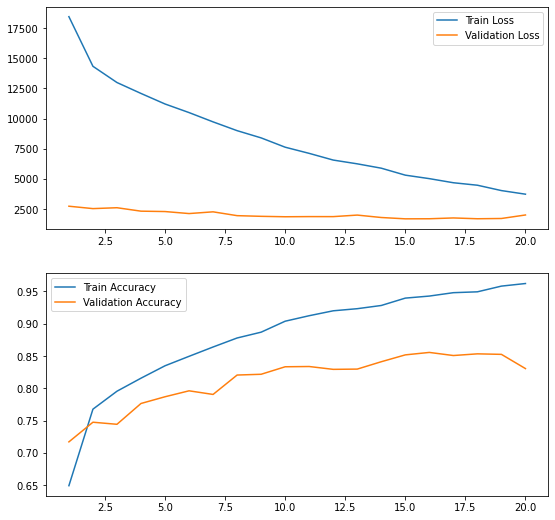

In [11]:
plot_loss_accuracy(trainLostList,valLossList,trainAccList,valAccList,num_epochs)

### For k = 3

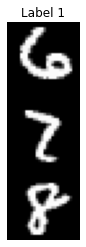

In [12]:
parityData3 = MNISTParityVertical(3, transforms = transforms)

parityData3.plotRandomData()

trainloaderParity3 = DataLoader(parityData3.trainset, batch_size=256, shuffle=True)
testloaderParity3 = DataLoader(parityData3.testset, batch_size=512, shuffle=True)

In [13]:
inputShape0, inputShape1 = parityData3.trainset.data[0].shape
print(inputShape0 * inputShape1)
model2 = MLP(inputShape0, inputShape1)
optimizer = torch.optim.Adadelta(model2.parameters(), lr=learn_rate)

trainLostList, trainAccList, valLossList, valAccList  = train_model(model2, trainloaderParity3, testloaderParity3, loss_fn, 
                                                                    optimizer, num_epochs, validate_model = True,
                                                                    performance=accuracy)

2352
Training on cuda:0
Epoch 1 completed. Loss - total: 13999.9595 - average: 0.7000; Performance: 0.5148
TESTING - loss 2330.575223326683 - performance 0.5038
Epoch 2 completed. Loss - total: 13627.7681 - average: 0.6814; Performance: 0.5588
TESTING - loss 2342.1324051618576 - performance 0.5020
Epoch 3 completed. Loss - total: 13361.8499 - average: 0.6681; Performance: 0.5980
TESTING - loss 2370.1666927337646 - performance 0.5179
Epoch 4 completed. Loss - total: 13059.4354 - average: 0.6530; Performance: 0.6246
TESTING - loss 2354.7602961063385 - performance 0.5044
Epoch 5 completed. Loss - total: 12707.5071 - average: 0.6354; Performance: 0.6522
TESTING - loss 2427.699428677559 - performance 0.5098
Epoch 6 completed. Loss - total: 12228.9350 - average: 0.6114; Performance: 0.6810
TESTING - loss 2530.0462985634804 - performance 0.5200
Epoch 7 completed. Loss - total: 11801.4594 - average: 0.5901; Performance: 0.6983
TESTING - loss 2478.4964290857315 - performance 0.5311
Epoch 8 comp

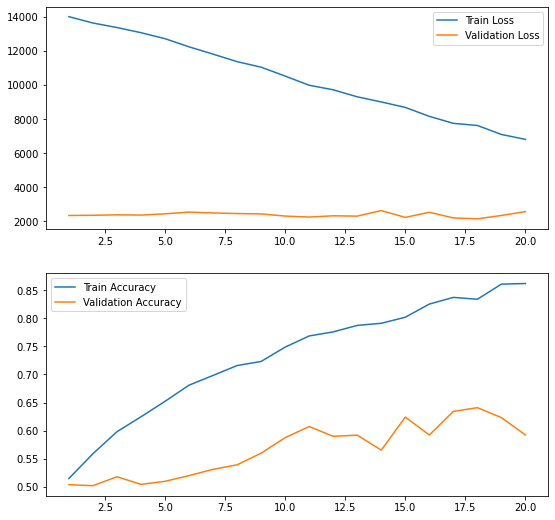

In [14]:
plot_loss_accuracy(trainLostList,valLossList,trainAccList,valAccList,num_epochs)

* For k=3, simple network can't learn but for k=2 it can, what is the main reason? (Check the paper one more time)
* Data is ready (hopefully), now we need to train with the proper models I think?

### Try with Horizontal Data

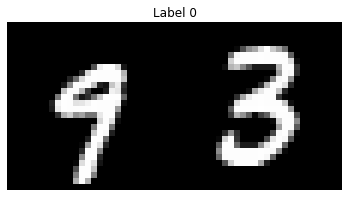

In [15]:
parityDataHor2 = MNISTParityHorizontal(2, transforms = transforms)
parityDataHor2.plotRandomData()

trainloaderParityHor2 = DataLoader(parityDataHor2.trainset, batch_size=128, shuffle=True)
testloaderParityHor2 = DataLoader(parityDataHor2.testset, batch_size=512, shuffle=True)

In [16]:
inputShape0, inputShape1 = parityDataHor2.trainset.data[0].shape
print(inputShape0 * inputShape1)

learn_rate = 0.1 # for SGD
num_epochs = 20
loss_fn = torch.nn.CrossEntropyLoss()


model3 = MLP(inputShape0,inputShape1)
optimizer = torch.optim.Adadelta(model3.parameters(), lr=learn_rate)

trainLostList, trainAccList, valLossList, valAccList  = train_model(model3, trainloaderParityHor2, testloaderParityHor2, loss_fn, 
                                                                    optimizer, num_epochs, validate_model = True,
                                                                    performance=accuracy)


1568
Training on cuda:0
Epoch 1 completed. Loss - total: 16950.5977 - average: 0.5650; Performance: 0.6912
TESTING - loss 2662.6356315612793 - performance 0.7258
Epoch 2 completed. Loss - total: 13027.3628 - average: 0.4342; Performance: 0.7932
TESTING - loss 2330.706928253174 - performance 0.7740
Epoch 3 completed. Loss - total: 11440.0246 - average: 0.3813; Performance: 0.8299
TESTING - loss 2203.7449021339417 - performance 0.8008
Epoch 4 completed. Loss - total: 10037.9280 - average: 0.3346; Performance: 0.8593
TESTING - loss 2015.1202230453491 - performance 0.8166
Epoch 5 completed. Loss - total: 8755.9982 - average: 0.2919; Performance: 0.8806
TESTING - loss 2149.2891585826874 - performance 0.7956
Epoch 6 completed. Loss - total: 7760.8426 - average: 0.2587; Performance: 0.8971
TESTING - loss 1815.104558467865 - performance 0.8306
Epoch 7 completed. Loss - total: 6805.1775 - average: 0.2268; Performance: 0.9159
TESTING - loss 1742.8129830360413 - performance 0.8458
Epoch 8 complet

In [17]:
test_model(model3, testloaderParityHor2, loss_fn = loss_fn)

TESTING - loss 1923.7340104579926 - performance 0.8624


(1923.7340104579926, 0.8624)

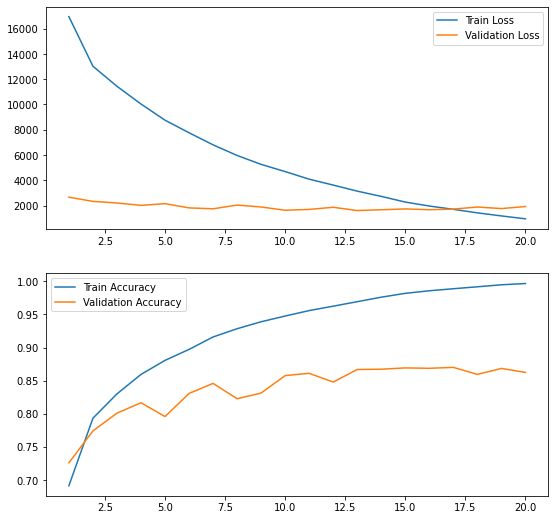

In [18]:
plot_loss_accuracy(trainLostList,valLossList,trainAccList,valAccList,num_epochs)

### For k = 3

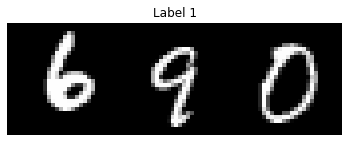

In [19]:
parityDataHor3 = MNISTParityHorizontal(3, transforms = transforms)
parityDataHor3.plotRandomData()

trainloaderParityHor3 = DataLoader(parityDataHor3.trainset, batch_size=256, shuffle=True)
testloaderParityHor3 = DataLoader(parityDataHor3.testset, batch_size=512, shuffle=True)

In [20]:
inputShape0, inputShape1 = parityDataHor3.trainset.data[0].shape
print(inputShape0 * inputShape1)

learn_rate = 0.1 # for SGD
num_epochs = 20
loss_fn = torch.nn.CrossEntropyLoss()


model4 = MLP(inputShape0,inputShape1)
optimizer = torch.optim.Adadelta(model4.parameters(), lr=learn_rate)

trainLostList, trainAccList, valLossList, valAccList  = train_model(model4, trainloaderParityHor3, testloaderParityHor3, loss_fn, 
                                                                    optimizer, num_epochs, validate_model = True,
                                                                    performance=accuracy)


2352
Training on cuda:0
Epoch 1 completed. Loss - total: 14048.1348 - average: 0.7024; Performance: 0.5104
TESTING - loss 2382.3088626265526 - performance 0.4944
Epoch 2 completed. Loss - total: 13626.8916 - average: 0.6813; Performance: 0.5635
TESTING - loss 2342.091367185116 - performance 0.5038
Epoch 3 completed. Loss - total: 13405.5962 - average: 0.6703; Performance: 0.5859
TESTING - loss 2376.4576973319054 - performance 0.5014
Epoch 4 completed. Loss - total: 13102.8112 - average: 0.6551; Performance: 0.6196
TESTING - loss 2399.373880624771 - performance 0.5098
Epoch 5 completed. Loss - total: 12792.7010 - average: 0.6396; Performance: 0.6428
TESTING - loss 2369.8742384910583 - performance 0.5074
Epoch 6 completed. Loss - total: 12399.7208 - average: 0.6200; Performance: 0.6630
TESTING - loss 2434.751126050949 - performance 0.5215
Epoch 7 completed. Loss - total: 11925.4898 - average: 0.5963; Performance: 0.6934
TESTING - loss 2488.417520940304 - performance 0.5263
Epoch 8 comple

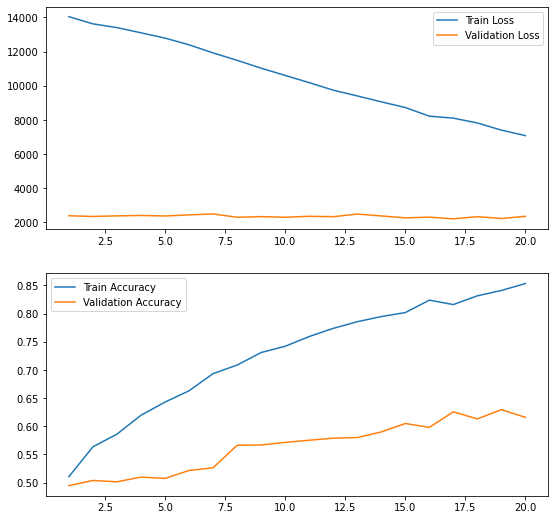

In [21]:
plot_loss_accuracy(trainLostList,valLossList,trainAccList,valAccList,num_epochs)

## TODO
* Debug the function (they are same but just in case) --> Debugged but they seem okay.
* Data part, check one more time                      --> Vertical one seems okay
* Also put reusable functions to scripts.py           --> Done
* Do it horizontally (Data) --> can be done with cat  --> Done